In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [70]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [71]:
from typing import List, Union, Tuple

def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - naive_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors)
    return result


def ZBMAE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Zero-Benchmarked Mean Absolute Error (ZBMAE) между фактическими и прогнозируемыми значениями.

    ZBMAE сравнивает среднюю абсолютную ошибку прогноза с средней абсолютной ошибкой наивного прогноза, который предполагает, что все прогнозируемые значения равны нулю. Это может быть полезно для временных рядов, где ожидается, что значения будут вокруг нуля.

    Параметры:
        y_true (pd.Series): Серия с фактическими значениями.
        y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
        float: Значение ZBMAE.
    '''
    zero_forecast = 0

    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - zero_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors.mean())
    return result

def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps) / 2
    result = (100 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result

def MDA(y_true: pd.Series, y_pred: pd.Series) -> float:

    '''
    Вычисляет Mean Directional Accuracy (MDA) между фактическими и прогнозируемыми значениями.

    MDA измеряет процент времени, когда прогноз и фактическое значение имеют одинаковое направление изменений (например, оба увеличиваются или оба уменьшаются).

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    actual_diff = np.diff(y_true)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(y_pred)
    predicted_signs = np.sign(predicted_diff)
    
    num_correct = np.sum(actual_signs == predicted_signs)
    
    mda = num_correct / (len(y_true) - 1)
    return 100*mda


def DMDA(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Direct Mean Directional Accuracy (DMDA) между фактическими и прогнозируемыми значениями.
    

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)

    result = (100 / len(y_true)) * np.sum(y_pred_sign == y_true_sign)
    return result

class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        data = data.sort_index()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame = None, date_variables: bool = False) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
            date_variables (bool): Будут ли добавлены переменные, связанные с датой.
        '''

        if other_variables is not None:
            if other_variables.isna().any().any():
                print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

            self.X = pd.concat([self.X, other_variables], axis=1, join='inner')


        if date_variables:
            self.X['days_since_start'] = (self.X.index - self.X.index[0]).days
            self.X['day'] = self.X.index.day
            self.X['dayofweek'] = self.X.index.dayofweek
            self.X['month'] = self.X.index.month
            self.X['year'] = self.X.index.year


        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)
        self.mda = MDA(self.y_true, self.y_pred)
        self.dmda = DMDA(self.y_true, self.y_pred)
        self.zbmae = ZBMAE(self.y_true, self.y_pred)
        self.mae = mean_absolute_error(self.y_true, self.y_pred)

        print(f'MAE: {self.mae:.4f}')
        print(f'MASE: {self.mase:.4f}')
        print(f'ZBMAE: {self.zbmae:.4f}')
        print(f'SMAPE: {self.smape:.4f}%')
        print(f'MDA: {self.mda:.4f}%')
        print(f'DMDA: {self.dmda:.4f}%')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

In [72]:
ts = TimeSeriesProcessor(data=data.MOEXCN)

Новый тип индексов: pd.DatetimeIndex


In [73]:
ts.add_lags(lags=[21, 22, 23, 24, 25, 26, 27, 30, 40, 50])

In [74]:
ts.add_other_variables(date_variables=True)

In [75]:
ts.get_folds(horizon=20, validation_part=0.3, num_recent_folds=20)

# Тестирование различных моделей

### Линейная регрессия

In [76]:
from sklearn.linear_model import LinearRegression

# Модель градиентного бустинга
lr_model = LinearRegression()

y_pred_list_lr = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    lr_model.fit(X_train, y_train)
    y_pred_lr = pd.Series(lr_model.predict(X_test), index=X_test.index)
    y_pred_list_lr.append(y_pred_lr)

100%|██████████| 20/20 [00:00<00:00, 135.06it/s]


In [77]:
ts.get_model_result(y_pred_list_lr) 

MAE: 0.0096
MASE: 0.7626
ZBMAE: 0.9883
SMAPE: 165.3862%
MDA: 54.1353%
DMDA: 58.5000%


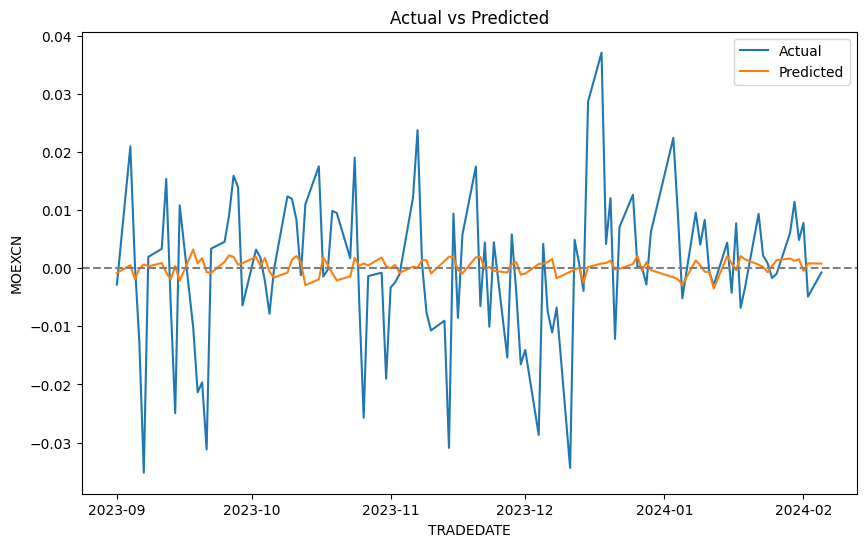

In [78]:
ts.get_visualisation(start_date='2023-09-01')

### Случайный лес

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
smape_scorer = make_scorer(SMAPE)

def objective(trial):
    
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Количество деревьев
    'max_depth': trial.suggest_int('max_depth', 3, 10),  # Максимальная глубина деревьев
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Минимальное количество выборок для разделения внутреннего узла
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # Минимальное количество выборок, необходимых для каждого листа
    'max_features': trial.suggest_int('max_features', 1, 10),  # Максимальное количество признаков для разбиения
}
    
    regressor = RandomForestRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=smape_scorer, 
            cv=5))

sampler = optuna.samplers.MOTPESampler()
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=30)

[I 2024-03-18 03:51:57,001] A new study created in memory with name: no-name-70154efb-dbb5-47d2-8ada-92d7e20c177a
[I 2024-03-18 03:52:01,366] Trial 0 finished with value: 166.7423528428195 and parameters: {'n_estimators': 216, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 1}. Best is trial 0 with value: 166.7423528428195.
[I 2024-03-18 03:52:10,288] Trial 1 finished with value: 155.762268267136 and parameters: {'n_estimators': 784, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 7}. Best is trial 1 with value: 155.762268267136.
[I 2024-03-18 03:52:14,881] Trial 2 finished with value: 162.46700251672104 and parameters: {'n_estimators': 761, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 2}. Best is trial 1 with value: 155.762268267136.
[I 2024-03-18 03:52:15,860] Trial 3 finished with value: 157.16859378658134 and parameters: {'n_estimators': 132, 'max_depth': 7, 'min_samples_split': 17, 

In [114]:
study.best_params

{'n_estimators': 784,
 'max_depth': 7,
 'min_samples_split': 11,
 'min_samples_leaf': 2,
 'max_features': 7}

In [115]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'y': [166.7423528428195, 155.762268267136, 162.46700251672104,
                    157.16859378658134, 156.35536194389692, 157.5227626028131,
                    158.32571949010975, 158.91328873780753, 160.23613736496537,
                    157.6576794079271, 156.02262046996233, 157.69886561992743,
                    156.0204114604673, 156.93234681092045, 157.58167554868655]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'y': [166.7423528428195, 155.762268267136, 155.762268267136,
                    155.762268267136, 155.762268267136, 155.762268267136,
                    155.762268267136, 155.762268267136, 155.762268267136,
                    155.762268267136, 155.762268267136, 155.762268267136,
                    155.762268267136, 155.762268267136, 155.762268267136]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [116]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [4, 7, 7, 7, 10, 4, 6, 5, 3, 10, 8, 9, 8, 6, 5],
              'xaxis': 'x',
              'y': [166.7423528428195, 155.762268267136, 162.46700251672104,
                    157.16859378658134, 156.35536194389692, 157.5227626028131,
                    158.32571949010975, 158.91328873780753, 160.23613736496537,
                    157.6576794079271, 156.02262046996233, 157.69886561992743,
                    156.0204114604673, 156.93234681092045, 157.58167554868655],
              'yaxis': 'y'},
             {'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [1, 7, 2, 5, 10, 5, 7, 8, 4, 10, 7, 3, 8, 6, 9],
              'xaxis': 'x2',
              'y': [166.7423528428195, 155.762268267136, 162.46700251672104,
                    157.16859378658134, 156.35536194389692, 157.5227626028131,
                    158.32571949010975, 158.91328873780753, 160.23613736496537,
                    157.6576794079271, 156.02262046996233, 157.69886561992743,
                    156.0204114604673, 156.93234681092045, 157.58167554868655],
              'yaxis': 'y2'},
             {'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
    

In [117]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_samples_split (IntDistribution):
                                0.040309970498416114<extra></extra>, n_estimators
                                (IntDistribution):
                                0.06489770896996931<extra></extra>,
                                min_samples_leaf (IntDistribution):
                                0.0931206983794893<extra></extra>, max_depth
                                (IntDistribution):
                                0.10903272527513504<extra></extra>, max_features
                                (IntDistribution):
                                0.6926388968769903<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.04, 0.06, 0.09, 0.11, 0.69],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.040309970498416114, 0.06489770896996931, 0.0931206983794893,
                    0.10903272527513504, 0.6926388968769903],
              'y': [min_samples_split, n_estimators, min_samples_leaf, max_depth,
                    max_features]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [118]:
# Модель случайного леса
rf_model = RandomForestRegressor(**study.best_params)

y_pred_list_rf = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    rf_model.fit(X_train, y_train)
    y_pred_rf = pd.Series(rf_model.predict(X_test), index=X_test.index)
    y_pred_list_rf.append(y_pred_rf) 

100%|██████████| 20/20 [03:13<00:00,  9.69s/it]


In [119]:
ts.get_model_result(y_pred_list_rf) 

MAE: 0.0098
MASE: 0.7761
ZBMAE: 1.0058
SMAPE: 174.0691%
MDA: 57.3935%
DMDA: 55.7500%


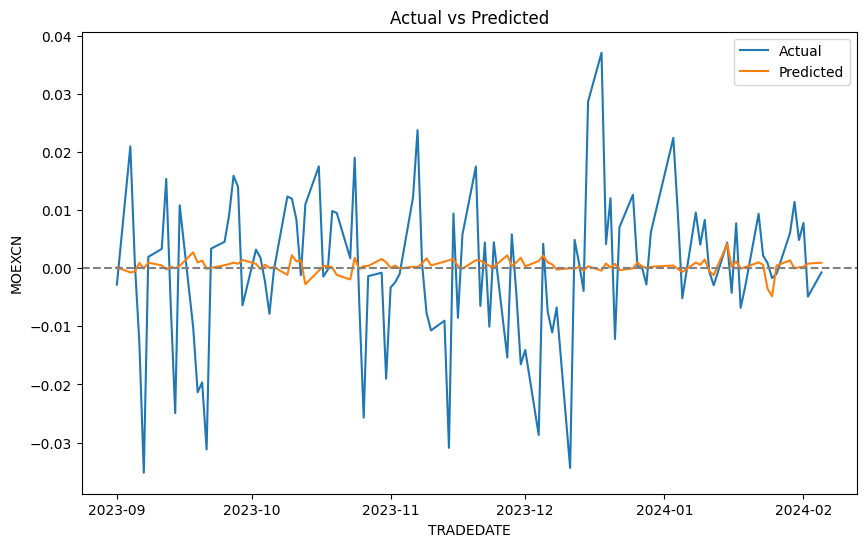

In [120]:
ts.get_visualisation(start_date='2023-09-01')

### Градиентный бустинг

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

# Модель градиентного бустинга
gb_model = GradientBoostingRegressor()

y_pred_list_gb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    gb_model.fit(X_train, y_train)
    y_pred_gb = pd.Series(gb_model.predict(X_test), index=X_test.index)
    y_pred_list_gb.append(y_pred_gb)

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


In [88]:
ts.get_model_result(y_pred_list_gb) 

MAE: 0.0101
MASE: 0.8037
ZBMAE: 1.0416
SMAPE: 157.6967%
MDA: 57.8947%
DMDA: 55.7500%


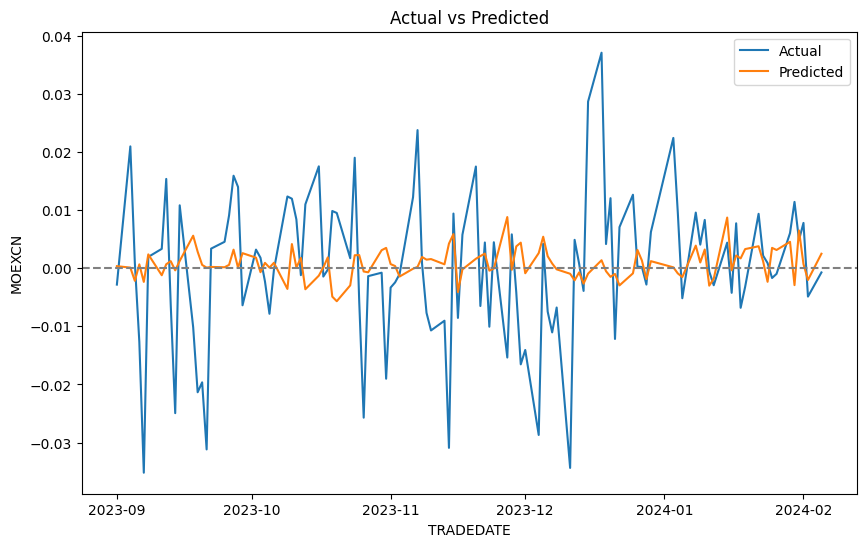

In [89]:
ts.get_visualisation(start_date='2023-09-01')

### Адаптивный бустинг

In [90]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_model = AdaBoostRegressor()

y_pred_list_adaboost = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    adaboost_model.fit(X_train, y_train)
    y_pred_adaboost = pd.Series(adaboost_model.predict(X_test), index=X_test.index)
    y_pred_list_adaboost.append(y_pred_adaboost)

100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


In [91]:
ts.get_model_result(y_pred_list_adaboost) 

MAE: 0.0121
MASE: 0.9596
ZBMAE: 1.2437
SMAPE: 166.0526%
MDA: 42.6065%
DMDA: 42.7500%


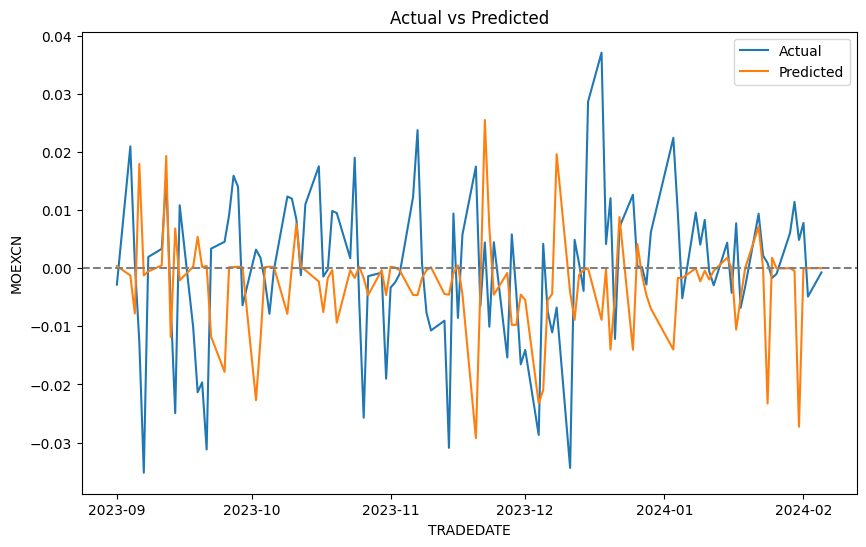

In [92]:
ts.get_visualisation(start_date='2023-09-01')

### Lasso-регрессия

In [93]:
from sklearn.linear_model import Lasso

model = Lasso()

y_pred_list = []
    
for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    
    model.fit(X_train, y_train)

    y_pred = pd.Series(
        model.predict(X_test),
        index=X_test.index
    )

y_pred_list.append(y_pred)

100%|██████████| 20/20 [00:00<00:00, 114.32it/s]


In [94]:
ts.get_model_result(y_pred_list) 

MAE: 0.0046
MASE: 0.7446
ZBMAE: 0.9973
SMAPE: 192.8655%
MDA: 0.0000%
DMDA: 55.0000%


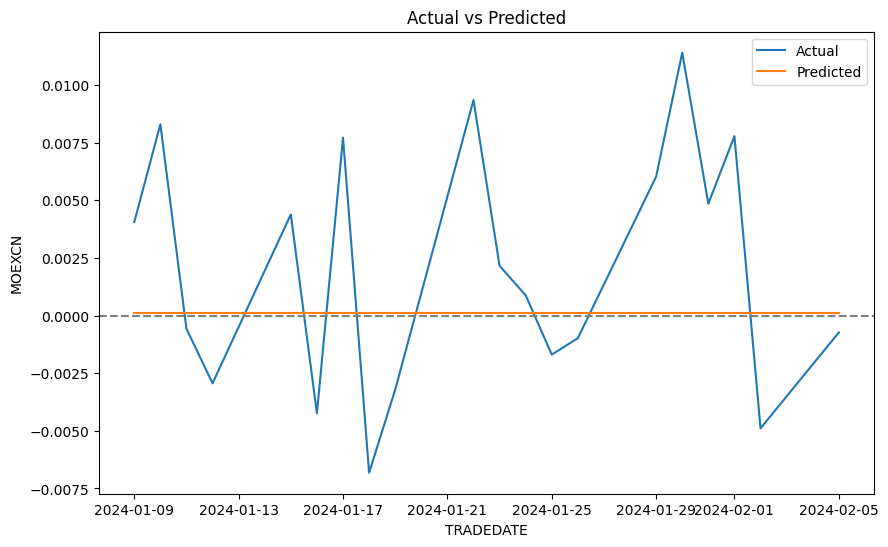

In [95]:
ts.get_visualisation(start_date='2023-09-01')

### Ridge-регрессия

In [96]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

y_pred_list_ridge = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = pd.Series(ridge_model.predict(X_test), index=X_test.index)
    y_pred_list_ridge.append(y_pred_ridge)

100%|██████████| 20/20 [00:00<00:00, 180.79it/s]


In [97]:
ts.get_model_result(y_pred_list_ridge) 

MAE: 0.0096
MASE: 0.7636
ZBMAE: 0.9896
SMAPE: 174.7614%
MDA: 57.8947%
DMDA: 58.0000%


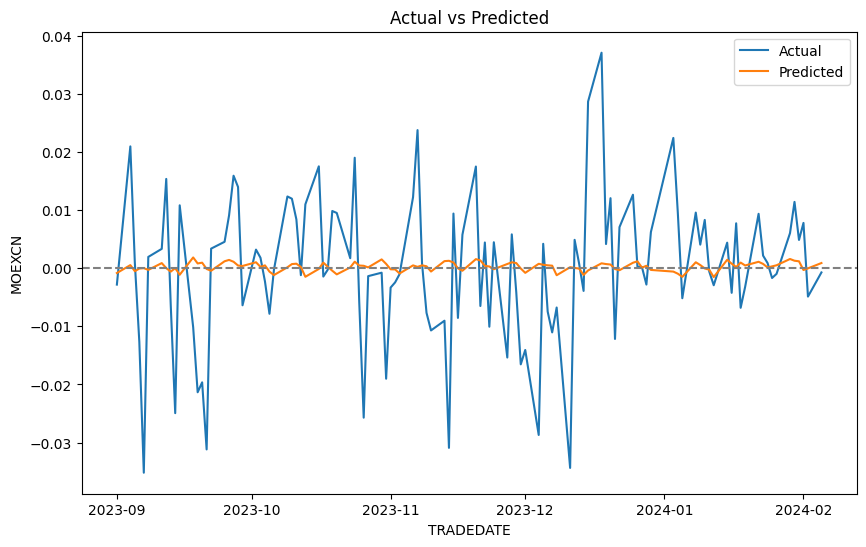

In [98]:
ts.get_visualisation(start_date='2023-09-01')

### К-ближайших соседей 

In [99]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

y_pred_list_knn = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    knn_model.fit(X_train, y_train)
    y_pred_knn = pd.Series(knn_model.predict(X_test), index=X_test.index)
    y_pred_list_knn.append(y_pred_knn)

100%|██████████| 20/20 [00:00<00:00, 66.76it/s]


In [100]:
ts.get_model_result(y_pred_list_knn) 

MAE: 0.0105
MASE: 0.8328
ZBMAE: 1.0793
SMAPE: 140.8012%
MDA: 25.3133%
DMDA: 54.0000%


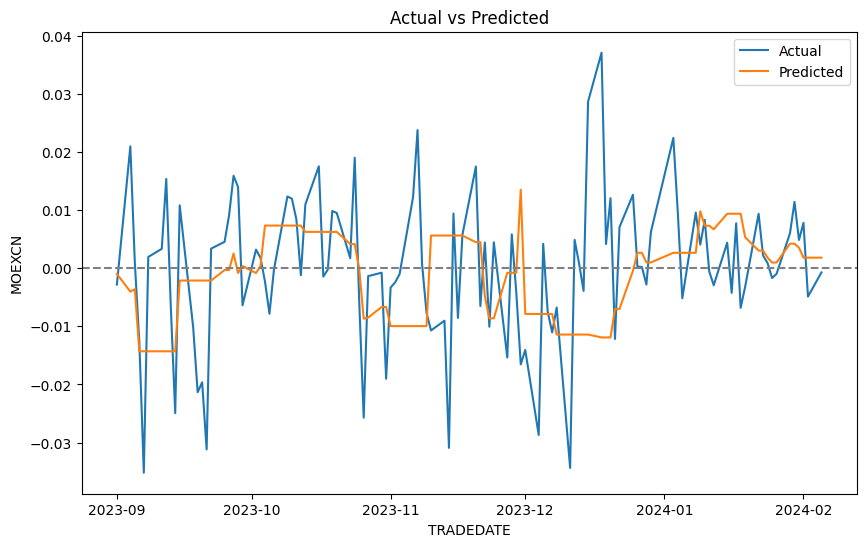

In [101]:
ts.get_visualisation(start_date='2023-09-01')

### XGBoost

In [102]:
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
SMAPE_scorer = make_scorer(SMAPE)

def objective(trial):
    
    param = {
    'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.3),  # Скорость обучения
    'max_depth': trial.suggest_int('max_depth', 2, 8),  # Максимальная глубина деревьев
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # Минимальное снижение значения функции потерь, чтобы сделать разделение
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),  # L1 регуляризация
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),  # L2 регуляризация
    'subsample': trial.suggest_float('subsample', 0.1, 1.0),  # Доля наблюдений, используемая для обучения каждого дерева
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # Доля признаков, используемая для обучения каждого дерева
    'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10.0),  # Минимальный вес дочерних узлов
    'n_estimators': trial.suggest_int('n_estimators', 50, 3000),  # Количество деревьев
    }
    
    regressor = xgb.XGBRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=SMAPE_scorer, 
            cv=5))

sampler = optuna.samplers.MOTPESampler()
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-03-18 03:36:14,098] A new study created in memory with name: no-name-e5b07bf4-d7e9-4c79-9510-2d26b9006a5f
[I 2024-03-18 03:36:14,412] Trial 0 finished with value: 162.558305267651 and parameters: {'learning_rate': 0.13650621878527378, 'max_depth': 2, 'gamma': 0.7505444052731778, 'reg_alpha': 1.981044388414483e-08, 'reg_lambda': 4.065464197096976e-08, 'subsample': 0.30728742358465766, 'colsample_bytree': 0.6244954627002116, 'min_child_weight': 7.4605455573263155, 'n_estimators': 319}. Best is trial 0 with value: 162.558305267651.
[I 2024-03-18 03:36:14,922] Trial 1 finished with value: 162.67470388886 and parameters: {'learning_rate': 0.13056337674430038, 'max_depth': 7, 'gamma': 0.6427532327186449, 'reg_alpha': 0.00357093765716497, 'reg_lambda': 0.5860242014452629, 'subsample': 0.4790735114277572, 'colsample_bytree': 0.5632328487818401, 'min_child_weight': 6.837312166381653, 'n_estimators': 888}. Best is trial 0 with value: 162.558305267651.
[I 2024-03-18 03:36:16,768] Trial 2 

In [103]:
study.best_params

{'learning_rate': 0.09790930600049143,
 'max_depth': 7,
 'gamma': 0.9995531888639805,
 'reg_alpha': 0.0015004872094130791,
 'reg_lambda': 7.143626780708177,
 'subsample': 0.13253347287785375,
 'colsample_bytree': 0.34731065444076475,
 'min_child_weight': 5.637125030728902,
 'n_estimators': 468}

In [104]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [162.558305267651, 162.67470388886, 168.9917729659096,
                    169.95676234896968, 170.2397071642744, 167.9964911794046,
                    165.3236384280599, 168.42698831741697, 172.02212723638917,
                    165.84048337320615, 166.32979586545056, 166.26588488353917,
                    165.20490743358133, 164.87628260825304, 165.4847160817341,
                    166.38888899140926, 173.12847207047813, 164.65398921680912,
                    166.26588488353917, 166.41785616235853, 168.30233159974466,
                    164.79894073251785, 168.90476141038562, 161.74561969707221,
                    166.9780857457756, 165.92218989833606, 164.6635994291358,
                    165.29976727022617, 166.2670545730655, 165.68686000886365,
                    166.40299842575172, 163.65002408740946, 163.0832333999801,
                    168.35015971684265, 169.122402569742, 165.08199630265875,
                    166.26588488353917, 163.72627044071345, 162.28229854084827,
                    163.46586886792664, 166.98285826401312, 168.19791372333455,
                    167.71878596843865, 162.56544071651717, 163.1124050849054,
                    169.47099758339976, 163.52887760388526, 166.26588488353917,
                    171.78504065841838, 163.25541472030213, 164.13600838444322,
                    164.89575412702786, 160.10160826418294, 168.03149844248045,
                    171.33394053159304, 171.52506913959428, 166.46013207143898,
                    172.69123367649462, 172.29072069604166, 162.216978753887,
                    160.70980748492858, 157.67100873935613, 163.73415595844534,
                    164.4173382667159, 165.31191128929703, 166.64575798344276,
                    166.35054336646948, 162.38339679573983, 165.47525891622834,
                    161.64392756398888, 161.90096300113706, 162.97419472270198,
                    160.60497747171522, 157.87858558297484, 165.27369976993478,
                    164.73511333576985, 167.83548884467393, 160.53475059567438,
                    166.73690902369611, 167.97824658031067, 167.42801619218403,
                    166.89282511965445, 165.33145410078686, 167.51779544666874,
                    165.433622816644, 169.81911782160353, 169.2374218833404,
                    164.1841376314215, 164.72745052590213, 169.06817296088178,
                    161.2236817302276, 162.3402299128194, 164.7685438719444,
                    166.08669503651453, 165.79876160416347, 159.95855468768707,
                    164.90852434789923, 160.4555365031606, 166.76303375031625,
                    168.3163439331537]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [162.558305267651, 162.558305267651, 162.558305267

In [105]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.6244954627002116, 0.5632328487818401, 0.38837971318120246,
                    0.6506077043951206, 0.9514808128900275, 0.9468083909949028,
                    0.2180746352299468, 0.9798874721693183, 0.6985827951344751,
                    0.9967867605448918, 0.1049493657464049, 0.38496810385688635,
                    0.7841342558453007, 0.3840706953834623, 0.8148800074328902,
                    0.4453584314746879, 0.2331585383018001, 0.502690842834458,
                    0.6088132739908962, 0.8380702786913986, 0.5664784490492305,
                    0.7203666350269603, 0.49239747484105806, 0.2925220965146383,
                    0.2657083262881966, 0.10265387506339918, 0.30045184436261346,
                    0.17590014439867763, 0.3150754564284596, 0.17035515954871194,
                    0.5790706662708776, 0.5061718580448615, 0.8762355993730958,
                    0.6745051644456582, 0.4404716980162887, 0.6176738185212399,
                    0.7419374583901158, 0.528916801326334, 0.34374226361898735,
                    0.33196058049869026, 0.4638826822727438, 0.411717567923095,
                    0.35571018169399793, 0.5414670303597815, 0.22754157938751218,
                    0.275401438499593, 0.18095990581393495, 0.14016386365514022,
                    0.4649670998604068, 0.3518100005453658, 0.5427532619239813,
                    0.6215101427173931, 0.576257093734264, 0.6579873022817453,
                    0.7772204882960319, 0.2832309865694705, 0.52239953165176,
                    0.5968025020773033, 0.42126413915693844, 0.4793413728534508,
                    0.467551966259496, 0.34731065444076475, 0.3514265159831617,
                    0.4816294760736919, 0.40427552139864914, 0.32072624456455906,
                    0.42386247805574995, 0.36417558200830896, 0.263994266607949,
                    0.45786089297363197, 0.4617373040868176, 0.4727071575694458,
                    0.44728572913830233, 0.4369100627414084, 0.4362015413704082,
                    0.403435853489891, 0.3722563252830533, 0.2981148568456441,
                    0.5154961183930096, 0.4510245435897014, 0.23929564959752014,
                    0.2965088942702619, 0.31225344103198516, 0.38381678777986206,
                    0.4286745993637552, 0.2543719352256083, 0.21112725926993797,
                    0.4862284801282999, 0.4

In [106]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [reg_alpha (FloatDistribution):
                                0.0010995392556652404<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.020863829249397656<extra></extra>, max_depth
                                (IntDistribution):
                                0.02666293209979548<extra></extra>, subsample
                                (FloatDistribution):
                                0.043120066342643655<extra></extra>, gamma
                                (FloatDistribution):
                                0.12457998263303703<extra></extra>, n_estimators
                                (IntDistribution):
                                0.12999971892617365<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.13352356653346148<extra></extra>,
                                min_child_weight (FloatDistribution):
                                0.1403105269209792<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.3798398380388468<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.02, 0.03, 0.04, 0.12, 0.13, 0.13, 0.14, 0.38],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0010995392556652404, 0.020863829249397656,
                    0.02666293209979548, 0.043120066342643655, 0.12457998263303703,
                    0.12999971892617365, 0.13352356653346148, 0.1403105269209792,
                    0.3798398380388468],
              'y': [reg_alpha, reg_lambda, max_depth, subsample, gamma,
                    n_estimators, colsample_bytree, min_child_weight,
                    learning_rate]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [107]:
xgb_model = xgb.XGBRegressor(**study.best_params)

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


In [108]:
ts.get_model_result(y_pred_list_xgb) 

MAE: 0.0097
MASE: 0.7678
ZBMAE: 0.9951
SMAPE: 182.1326%
MDA: 1.5038%
DMDA: 57.5000%


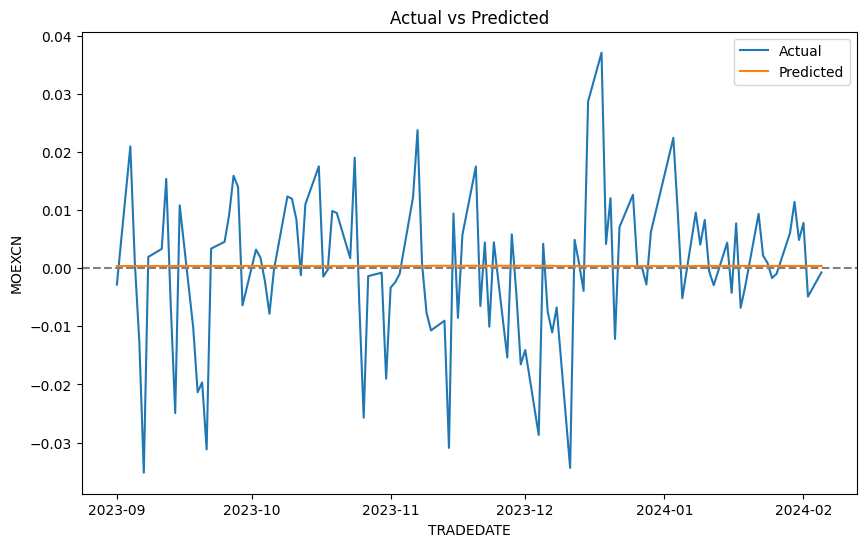

In [109]:
ts.get_visualisation(start_date='2023-09-01')

In [110]:
#Без поиска параметров работает лучше почему-то..
xgb_model = xgb.XGBRegressor()

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


In [111]:
ts.get_model_result(y_pred_list_xgb) 

MAE: 0.0119
MASE: 0.9394
ZBMAE: 1.2174
SMAPE: 140.7259%
MDA: 59.6491%
DMDA: 59.0000%


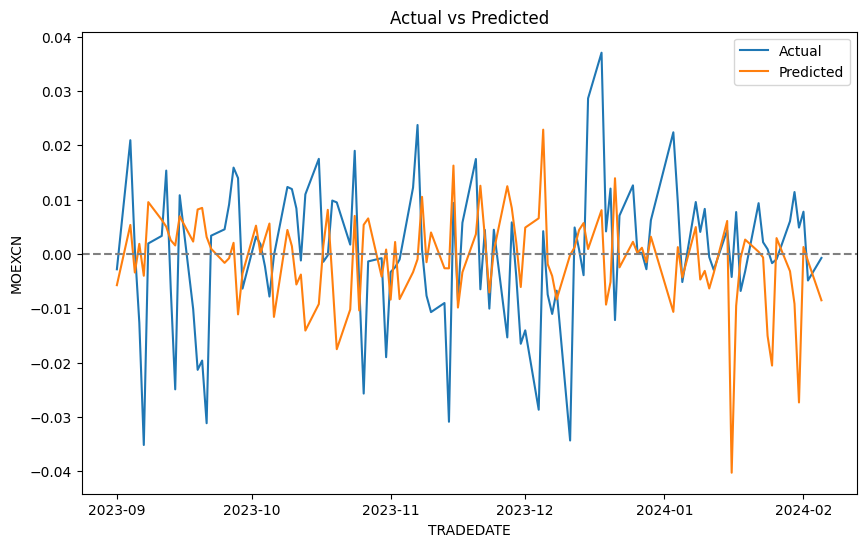

In [112]:
ts.get_visualisation(start_date='2023-09-01')